In [97]:
#General
import pandas as pd
import numpy as np
import numpy.linalg as alg
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

#Seasonality Testing
from statsmodels.tsa.seasonal import STL
#Glasso
from sklearn import covariance
from sklearn.exceptions import ConvergenceWarning

import warnings

#TVGlasso
from gglasso.problem import glasso_problem
from gglasso.solver.admm_solver import ADMM_MGL
sns.set_theme(rc={'figure.figsize': (12,8)})

#DrawProgressBar
import sys

In [117]:
def decompose_and_visualize(df, node):
    decompositions = {}

    for column in df.columns:
        stl = STL(df[column])
        results = stl.fit()
        decompositions[column] = results

    #Visualize the seasonality for a specific node.
    trend = decompositions[node].trend
    seasonal = decompositions[node].seasonal
    residual = decompositions[node].resid
    plt.figure(figsize = (12,8))

    plt.subplot(221)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')


    plt.subplot(222)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')

    plt.subplot(223)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')


    plt.subplot(224)
    plt.plot(df[node], label = "Actual")
    plt.legend(loc = 'best')

    plt.show()
    return decompositions
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [118]:
df = pd.read_csv('../NetworkDataSets/SHCFull.csv').drop(["Unnamed: 0"], axis = 1)

#Fix into node, timestamp column
df= df.groupby(['Cell', "Observation Date"]).size().reset_index(name='n').pivot(index = 'Observation Date', columns = "Cell", values = "n").fillna(value = 0)

#Convert the index to Dattime
df.index = pd.to_datetime(df.index)


df.head()

Cell,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,535
Observation Date,,,,,,,,,,,,,,,,,,,,,
1819-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1820-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1823-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1830-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1842-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


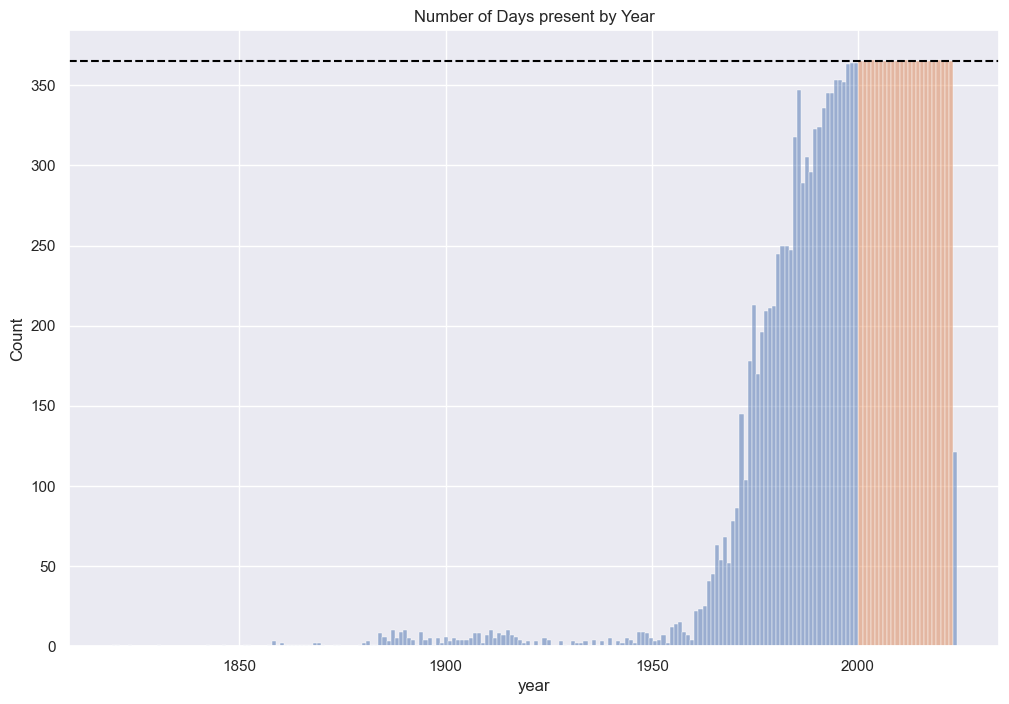

In [119]:
#We want to plot the number of days in each year where we have events, for consistency we want the earlier year that has >= 365 days on that year and all following.
df['good'] = df.groupby(df.index.year).transform('size') >= 365
df['year'] = df.index.year
ax = sns.histplot(data = df, x = 'year', hue = 'good', bins = df.year.max() - df.year.min() + 1)
ax.axhline(y = 365, color = 'black', linestyle = '--')
df = df.drop(['good', 'year'], axis = 1)
ax.get_legend().remove()
ax.set_title("Number of Days present by Year")
plt.show()

In [120]:
#Filter data from 2001 to 2023, and then continue with our process.
time_span = df.index.to_series().between('2010-01-01', '2023-12-31') 

df = df[time_span]

#We also want to do a rolling 14 day sum, in order to increase the strength of each covariance to help the model out.
df = df.rolling(21, center = True, step = 7).sum().dropna()

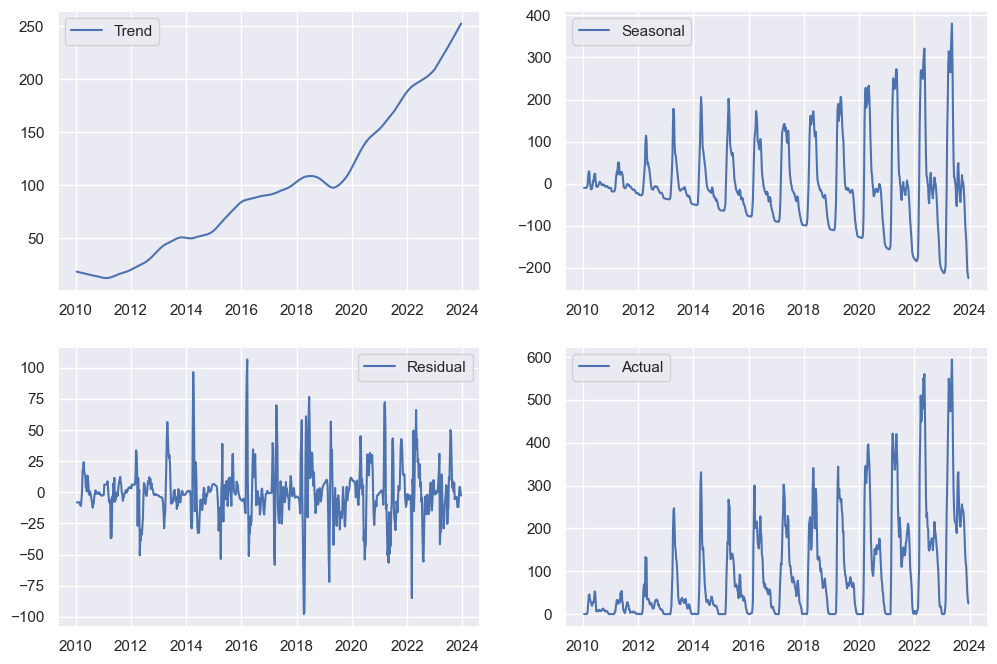

In [121]:
#Now, we want to look at the seasonality of the data.


decompositions = decompose_and_visualize(df, 301)

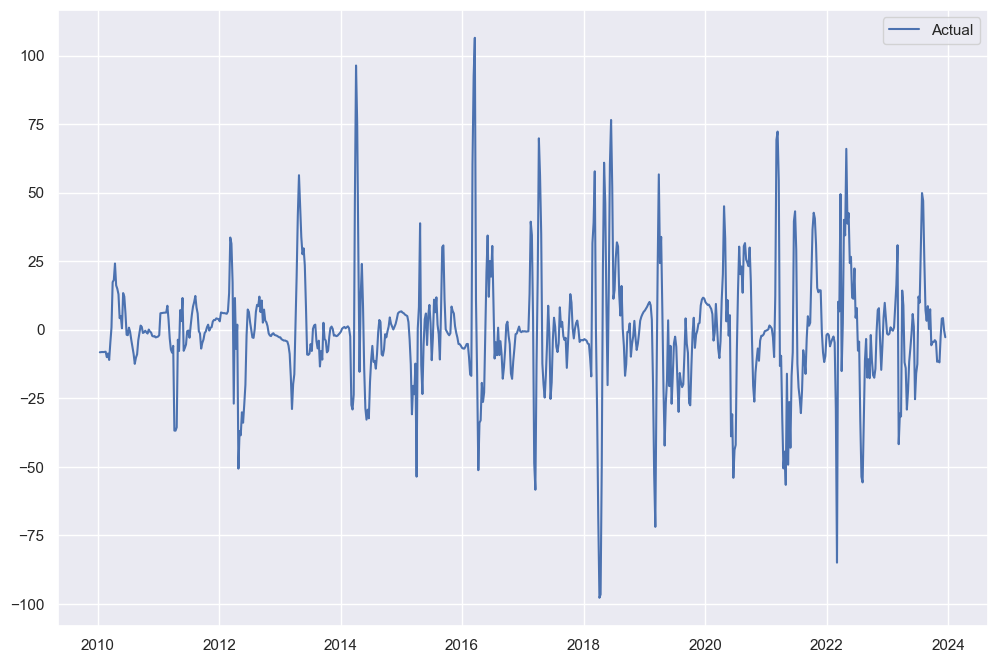

In [122]:
#We want to adjust for the long term trend by having each node be the proportion of birds seen on a day, and we adjust for the overall trend in the mean and variance with new = old - trend, because migrations are seasonal we arent removing seasonal part. This won't affect the covariance, the timing of it so our model will still show some results when we compare with outside factors.
df = df.apply(lambda x: x - decompositions[x.name].trend - decompositions[x.name].seasonal, axis = 0) # Remove trend to account for increase in apps popularity.

plt.plot(df[301], label = "Actual")
plt.legend(loc = 'best')
plt.show()

In [123]:
#We want to understand migration, which is the movement of the birds, so the values of change are more important the actual values.
for col in df.columns:
    df[col] =  df[col].diff()
df = df.dropna()

In [196]:

#Now, create an empirical covariance matrix for each month for the years 2001 to 2023. We will use the TV-Glasso on all of these to create the edges for the network.
N = len(df.index.year.unique())
sample_n = []
emp_covs = np.zeros(shape=(N, df.shape[1], df.shape[1]))
for i, (year, data) in enumerate(df.groupby(df.index.year)):
    emp_covs[i, :, :] = covariance.empirical_covariance(data.values.astype('float64'), assume_centered=True)
    sample_n.append(data.shape[0])


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

[ ====                 ] 20.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ======               ] 30.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ========             ] 40.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ==========           ] 50.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ============         ] 60.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ==============       ] 70.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ================     ] 80.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ==================   ] 90.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ==================== ] 100.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


[ ==================== ] 110.00%

C:\Users\bobby\AppData\Local\Temp\ipykernel_8932\3970576106.py:4: RuntimeWarning: divide by zero encountered in log
  BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)


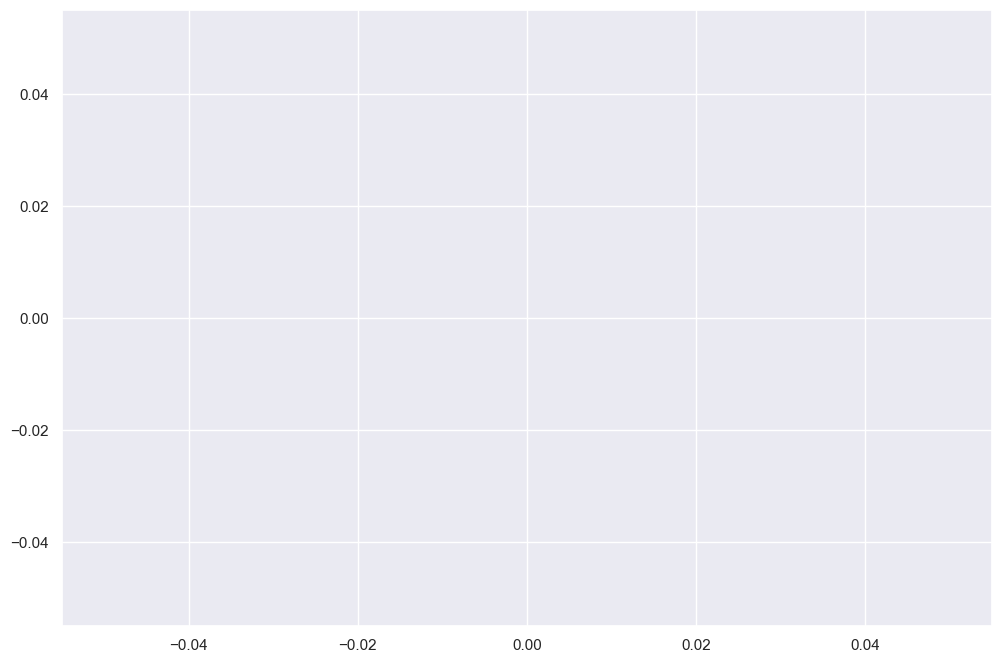

In [205]:
#BIC Analysis with midrange year.
shrunk_cov = covariance.shrunk_covariance(emp_covs[10,:,:], shrinkage = 0.8)

BIC = lambda E, n, Theta, S: -n*(np.log(np.linalg.det(Theta)) - np.trace(np.matmul(S, Theta))) + E*np.log(n)
i = 0
alphas = 10
alphaRange = np.linspace(0.1, 1, alphas)# 1e-7 to 1e-1 by order of magnitude
bic_values = {}
n = sample_n[13]
for alpha in alphaRange:
    try: 
        graphCov = covariance.graphical_lasso(shrunk_cov, alpha)
        E = (np.count_nonzero(graphCov[1]) - n)/2
        bic_values[alpha] = BIC(E, n, graphCov[1], shrunk_cov)
    except FloatingPointError:
        print(f"Failed at alpha={alpha}")
    i += 1
    drawProgressBar((i)/alphas)
x = bic_values.keys()
y = bic_values.values()
plt.scatter(x = x, y = y,s = 0.3)
plt.show()


The matrix Glasso_cov is returning is signular, so it keeps getting the non zero matrix issue. ways to fix:
1. Don't have this issue, i.e. make it return nonsingular
2. Look for other methods of determining alpha

In [206]:
#Skip this part? Just go straight to TVGLasso?
glasso_covs = np.zeros(shape=(N, df.shape[1], df.shape[1]))
for i, emp_cov in enumerate(emp_covs): 
    emp_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.6)# Set shrinkage closer to 1 for poorly-conditioned data
    glasso_covs[i, :, :] = covariance.graphical_lasso(emp_cov, 1, max_iter=500)[1] # The higher alpha is, the less edges
    drawProgressBar((i+1)/N)

[ ==                   ] 14.29%

c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: -4.880e-04
  warnings.warn(


[ ==========           ] 50.00%

c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: 5.046e-03
  warnings.warn(


[ ============         ] 64.29%

c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: -3.802e-03
  warnings.warn(


[ ==================== ] 100.00%

In [207]:
graphs = []
in_use_nodes = set()
for cov in glasso_covs:
    g = nx.Graph()
    edges = []
    for i in range(cov.shape[0]):
        for j in range(i+1, cov.shape[0]):
            if abs(cov[i,j]) > 0:
                edges.append((i,j))
                in_use_nodes.add(i)
                in_use_nodes.add(j)
    g.add_edges_from(edges)
    graphs.append(g)
    print(len(edges))


870
2283
4724
5257
6983
9187
10981
13672
16962
19518
23040
27485
27673
18218


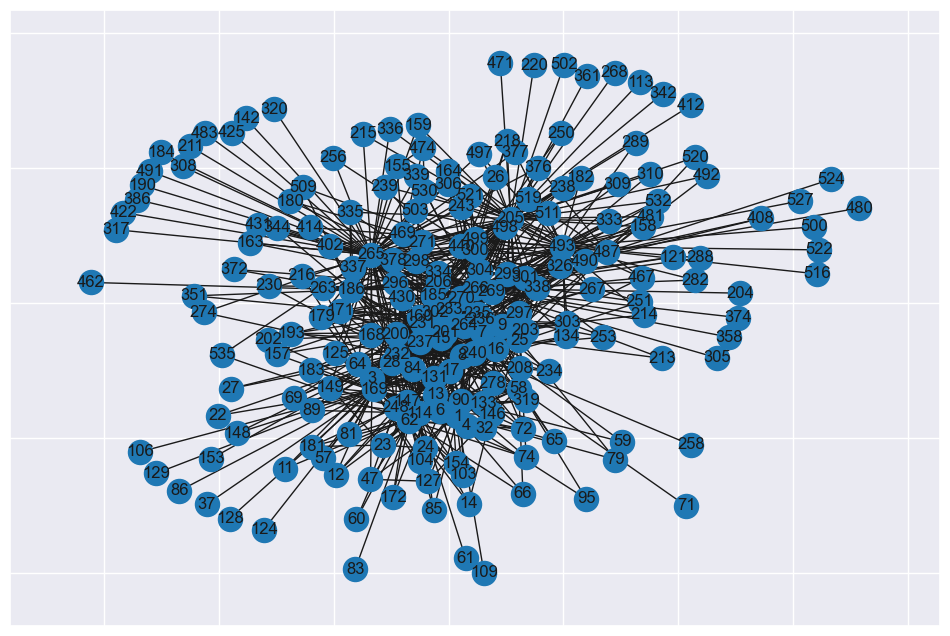

In [209]:
nx.draw_networkx(graphs[0])

In [155]:
params = {
    'lambda1': 0.001,
    'lambda2': 0.001
}
problem = glasso_problem(emp_covs, 30, reg = 'FGL', reg_params = params)
solution = problem.solve()

KeyboardInterrupt: 

Cell,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,535
Observation Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,-0.008436,0.009885,-0.000169,0.017973,-0.000663,-0.000135,-0.017375,-0.011403,-0.021529,0.010266,...,-0.000042,0.000006,-0.000014,0.000014,0.000158,-0.000016,-1.183458e-03,-0.000060,0.010356,-0.008660
2010-01-16,0.000080,0.008033,0.000039,0.008334,0.000260,0.000061,-0.007253,0.000633,0.008593,-0.037440,...,-0.000016,-0.000109,-0.000058,-0.000075,-0.000307,-0.000004,-1.860166e-04,0.007687,0.000033,0.007787
2010-01-17,0.000293,0.024973,0.000193,-0.007961,0.000796,0.000215,0.007063,-0.006718,-0.025918,-0.008886,...,-0.000003,-0.000222,-0.000106,-0.000159,-0.000721,0.000003,4.298731e-04,0.000076,0.000133,0.017427
2010-01-18,0.000493,0.010478,0.000340,0.002891,0.001387,0.000359,0.011060,0.002850,0.035399,0.021891,...,0.000010,-0.000324,-0.000149,-0.000236,-0.001102,0.000011,1.038047e-03,0.000131,0.000228,0.009817
2010-01-19,-0.009812,0.000057,-0.000023,0.010190,-0.000070,0.000010,-0.000006,-0.000682,0.021937,0.000296,...,-0.000029,-0.000101,-0.000059,-0.000066,-0.000234,-0.000009,-5.900530e-04,-0.000004,-0.000003,0.010643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.004139,0.013760,0.001774,0.013693,0.012082,0.005432,0.009968,0.013859,-0.003928,0.010931,...,0.000032,0.000004,0.000214,0.000011,0.000002,0.000006,-9.846515e-07,0.007430,0.000106,0.003280
2023-12-28,0.005628,0.008932,0.000114,-0.014118,-0.000140,-0.000188,0.006493,0.017713,-0.001623,0.002487,...,0.000033,0.000025,0.000239,0.000038,0.000007,0.000074,2.158519e-05,0.021344,0.000045,-0.005801
2023-12-29,0.007972,0.004307,0.000138,0.023069,0.002863,0.000512,0.006696,0.031970,-0.014691,-0.032290,...,0.000027,0.000003,0.000179,0.000008,0.000002,0.000004,-1.487816e-06,0.002973,0.000091,0.021550
